# Sklearn Example: LogisticRegression and Iris

In this example we will train as LogisticRegression model on the iris dataset, convert it to ONNX format, simulate historical treatment data, then estimate the treatment effects using our IV estimation method.

### 1. Train and Convert

In [58]:
import sys
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.datasets import load_iris

In [59]:
iris = load_iris()
X, y = iris.data, iris.target

In this example, X consists of 4 continuous variables

In [60]:
print("Dtype:", X.dtype, "\nShape:", X.shape)

Dtype: float64 
Shape: (150, 4)


Our estimation method relies on binary treatment assignment, so here let's assume that iris classifications of 1 or 2 indicate treatment recommendation.

In [61]:
y[y>0] = 1

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [63]:
clr = LogisticRegression()
clr.fit(X_train, y_train)

LogisticRegression()

In [64]:
clr.predict_proba(X_test)[:5]

array([[9.07293933e-03, 9.90927061e-01],
       [8.90170164e-04, 9.99109830e-01],
       [7.70185814e-04, 9.99229814e-01],
       [9.82250197e-01, 1.77498030e-02],
       [9.57786034e-01, 4.22139656e-02]])

In [65]:
import pickle 

# Save model
with open(f"models/iris_logreg.pickle", "wb") as f:
    pickle.dump(clr, f)

Now let's load back in the model and convert to ONNX. This step is necessary because our QPS estimation procedure only takes ONNX models for inference.

In [66]:
model = pickle.load(open(f"models/iris_logreg.pickle", 'rb'))
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

The mlisne package provides an ONNX conversion wrapper function that requires a dummy input and framework string to process datatypes and run the correct conversion function.

In [67]:
from mlisne import convert_to_onnx

X_dummy = X[0,:]
filename = "models/iris_logreg.onnx"

convert_to_onnx(model = model, dummy_input = X_dummy, path = filename, framework = "sklearn")

True

The wrapper function will also pass on any keyword arguments to the downstream conversion function

In [68]:
convert_to_onnx(model=model, dummy_input=X_dummy, path=filename, framework="sklearn", target_opset=12, 
                doc_string="Sklearn LogisticRegression model trained on iris dataset")

True

### 2. Simulate historical treatment data

Let's simulate treatment and non-treatment outcomes for each observation i with the following structural equations:
\begin{align}
Y_{0i} &= \mathcal{N}(2,2)x_{1i} + \mathcal{N}(3,1)x_{2i} + \mathcal{N}(0,3) \\
Y_{1i} &= Y_{0i} + \mathcal{N}(5,1) + \mathcal{N}(0,1)
\end{align}

Where $x_{1}$ and $x_{2}$ refer to the first and second variables of input X. 

In [69]:
# Generate coefficients for observations
b1 = np.random.normal(2,2,len(X))
b2 = np.random.normal(3,1,len(X))
e0 = np.random.normal(0,3,len(X))
treatment_effect = np.random.normal(5,1, len(X))
e1 = np.random.normal(0,1,len(X))

In [70]:
Y0 = b1 * X[:,0] + b2 * X[:,1] + e0
Y1 = Y0 + treatment_effect + e1

Generate treatment recommendation probabilities using our trained model. Let's assume that the treatment is assigned when the model recommends assignment 75% of the time (no-defiers assumption).

In [71]:
# Create treatment recommendation probabilities
Z_probs = clr.predict_proba(X)[:,1]
Z_probs[:5]

array([0.02035654, 0.02828087, 0.0177498 , 0.02821133, 0.01792077])

In [72]:
# Draw treatment recommendations
recommend_prob = np.random.uniform(size=len(X))
Z = (recommend_prob <= Z_probs).astype(int)
Z[:5]

array([0, 0, 0, 0, 0])

In [73]:
# Realized assignment follows recommended assignment 75% of the time
treatment_prob = np.random.uniform(size=len(X))
D = []
for i in range(len(treatment_prob)):
    if Z[i] == 1:
        if treatment_prob[i] >= 0.75:
            D.append(0)
        else:
            D.append(1)
    else:
        D.append(Z[i])

In [74]:
sim_data = np.stack((Y0, Y1, Z, D), axis=1)
sim_data.shape

(150, 4)

In [75]:
full_data = np.concatenate((sim_data, X), axis=1)
full_data.shape

(150, 8)

In [76]:
# Save to csv
cols = ['Y0', 'Y1', 'Z', 'D', 'X1', 'X2', 'X3', 'X4']
df = pd.DataFrame(data = full_data, columns=cols)
df['Y'] = df['Y1']
df.loc[df['D']==0, 'Y'] = df.loc[df['D']==0, 'Y0']
df.to_csv("data/iris_data.csv", index=False)

In [77]:
# Treatment effects 
constant = df.Y0.mean()
ate = (df.Y1 - df.Y0).mean()
atet = (df.loc[df['D'] == 1, 'Y1'] - df.loc[df['D'] == 1, 'Y0']).mean()
late = (df.loc[(df['D'] == df['Z']), 'Y1'] - df.loc[(df['D'] == df['Z']), 'Y0']).mean()
print(f"Constant: {constant}")
print(f"ATE: {ate}")
print(f"ATET: {atet}")
print(f"LATE: {late}")

Constant: 20.92414743626981
ATE: 4.913504170929344
ATET: 5.0566593052590845
LATE: 4.982711945153069


### 3. QPS Estimation

We can pass the simulated historical data and path to the ONNX model directly into our QPS estimation function.

In [78]:
from mlisne import estimate_qps_onnx

The data can be passed in a variety of ways. You can pass the entire dataset with optional variable indices delineating the continuous and discrete variables, the input variables individually, or some combination of the two. If incomplete information is passed, then the remaining data will be inferred **greedily**. That is, the remaining data will be assumed to be of whatever type that is not explicitly delineated. If no indices or explicit variables are given, then all of the data will be assumed to be continuous.

For this example, our input data is all continuous.

In [79]:
df.head()

,Y0,Y1,Z,D,X1,X2,X3,X4,Y
0,11.377491,15.210692,0.0,0.0,5.1,3.5,1.4,0.2,11.377491
1,25.096364,30.180974,0.0,0.0,4.9,3.0,1.4,0.2,25.096364
2,13.755396,20.180540,0.0,0.0,4.7,3.2,1.3,0.2,13.755396
3,-2.640681,2.458502,0.0,0.0,4.6,3.1,1.5,0.2,-2.640681
4,30.830661,34.972890,0.0,0.0,5.0,3.6,1.4,0.2,30.830661


In the below cell, we set a random seed and demonstrate different ways of passing data.

In [80]:
seed = np.random.choice(range(100))

# Pass just the input columns -- all variables are assumed to be continuous
qps0 = estimate_qps_onnx(data=df[['X1', 'X2', 'X3', 'X4']], S=100, delta=0.8, ML_onnx=filename, seed = seed)

# Pass the full dataset along with indices 
qps1 = estimate_qps_onnx(data=df[['X1', 'X2', 'X3', 'X4']], C = range(4), S=100, delta=0.8, ML_onnx=filename, seed = seed)

# Pass the continuous columns into the X_c variable
qps2 = estimate_qps_onnx(X_c=df[['X1', 'X2', 'X3', 'X4']], S=100, delta=0.8, ML_onnx=filename, seed = seed)

assert np.array_equal(qps0, qps1)
assert np.array_equal(qps1, qps2)

d:\tobin\mlisne\mlisne\qps.py:176: UserWarning: `data` given but no indices passed. We will assume that all the variables in `data` are continuous.
  print("`data` given but no indices passed. We will assume that all the variables in `data` are continuous.")


**Important:** to allow for cross-framework compatibility, our qps estimation function only works with ONNX models that take single inputs or separate continuous/discrete inputs with specified node names, and outputs with specified node names. The convert_to_onnx function will output with those settings automatically, but please keep this in mind if you plan on using an externally generated ONNX model.

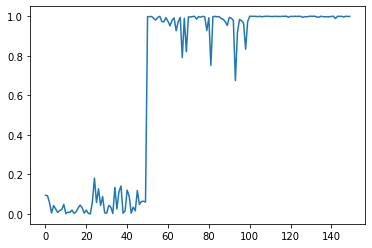

In [81]:
import matplotlib.pyplot as plt

plt.plot(qps0)

The converted ONNX model sets expected input dtypes according to the dummy input, but you can also pass the continuous/discrete datatypes explicitly as a tuple to coerce the input data to a specific type.

In [82]:
df[['X1', 'X2', 'X3', 'X4']].dtypes

X1    float64
X2    float64
X3    float64
X4    float64
dtype: object

In [83]:
qps = estimate_qps_onnx(data=df[['X1', 'X2', 'X3', 'X4']], S=100, delta=0.8, ML_onnx=filename, types=(np.float64, np.float64))
qps[:5]

d:\tobin\mlisne\mlisne\qps.py:176: UserWarning: `data` given but no indices passed. We will assume that all the variables in `data` are continuous.
  print("`data` given but no indices passed. We will assume that all the variables in `data` are continuous.")


array([0.02808571, 0.00923914, 0.06486332, 0.00623858, 0.02659267])

### 4. Treatment effect estimation

We can now estimate LATE using our IV approach. Our primary estimation function is `estimate_treatment_effect`. Similar to QPS estimation, we can pass in our inputs in a variety of ways. The function returns a tuple containing an array of counterfactual values and the fitted estimation model. Our package makes use of the modules in the `linearmodels` package to estimate and output the fitted models. 

In [84]:
from mlisne import estimate_treatment_effect

In [85]:
# Again we demonstrate the different ways of passing inputs
treatment_df = pd.DataFrame({"Y": df['Y'], 'Z': df['Z'], 'D': df['D'], 'QPS':qps})

# Without any indices passed, the function will infer all the variable columns
model0 = estimate_treatment_effect(data = treatment_df)

# We can specify some of the indices
model1 = estimate_treatment_effect(data = treatment_df, D_ind = 2, Y_ind = 0)

# We can also pass a subset of the variables directly
model2 = estimate_treatment_effect(data = treatment_df[['Z', 'D']], Y = treatment_df['Y'], qps = treatment_df['QPS'])

# We can also pass all the variables directly
model3 = estimate_treatment_effect(Y = treatment_df['Y'], Z = treatment_df['Z'], D = treatment_df['D'], qps = treatment_df['QPS'])

assert np.allclose(model0.params.to_numpy().flatten(), model1.params.to_numpy().flatten())
assert np.array_equal(model1.params.to_numpy().flatten(), model2.params.to_numpy().flatten())

Indices for ['Y', 'Z', 'D', 'QPS'] not explicitly passed. Assuming remaining columns in order ['Y', 'Z', 'D', 'QPS']...
We will fit on 150 values out of 150 from the dataset for which the QPS estimation is nondegenerate.
                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                     -0.0016
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0152
No. Observations:                 150   F-statistic:                    5.5718
Date:                Fri, Sep 18 2020   P-value (F-stat)                0.0617
Time:                        13:48:58   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI  

In [86]:
b0, b1, b2 = model0.params.to_numpy()
print("Treatment effect estimate:", b2)
print("True LATE:", late)

Treatment effect estimate: 5.5247580595516865
True LATE: 4.982711945153069


The fitted model also provides other estimation diagnostics

In [87]:
# First stage details
fs = model0.first_stage.individual['D']

print("First stage coefficients:", fs.params)
print("First stage p-values:", fs.pvalues)
print("First stage r2:", fs.rsquared)

First stage coefficients: const    0.013376
qps     -0.243146
Z        1.003502
Name: parameter, dtype: float64
First stage p-values: const    0.000103
qps      0.000671
Z        0.000000
Name: pvalue, dtype: float64
First stage r2: 0.5441074222268663


In [88]:
print(fs)

                            OLS Estimation Summary                            
Dep. Variable:                      D   R-squared:                      0.5441
Estimator:                        OLS   Adj. R-squared:                 0.5379
No. Observations:                 150   F-statistic:                    614.58
Date:                Fri, Sep 18 2020   P-value (F-stat)                0.0000
Time:                        13:48:58   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0134     0.0034     3.8823     0.0001      0.0066      0.0201
qps           -0.2431     0.0715    -3.4010     0.00